# Réduction de dimension

Après avoir utilisé un réseau comme VGG16 et le transfert learning sur les images brutes, il apparaît que le temps d'apprentissage est suffisamment long pour nous empêcher d'itérer sur notre réseau de neurones secondaires. Il faut donc réduire la taille des images (largeur, hauteur ou nombre de canaux de couleur)

Le problème, c'est que quelque soit la méthode, nous allons perdre de l'information utile. Il est possible de conserver que l'information utile dans l'image. En effet, sur quelques essais effectués au hasard sur des images, il apparaît que seul 20% de l'information est utile. Nous pourrions donc réduire d'environ 80% la taille des images.

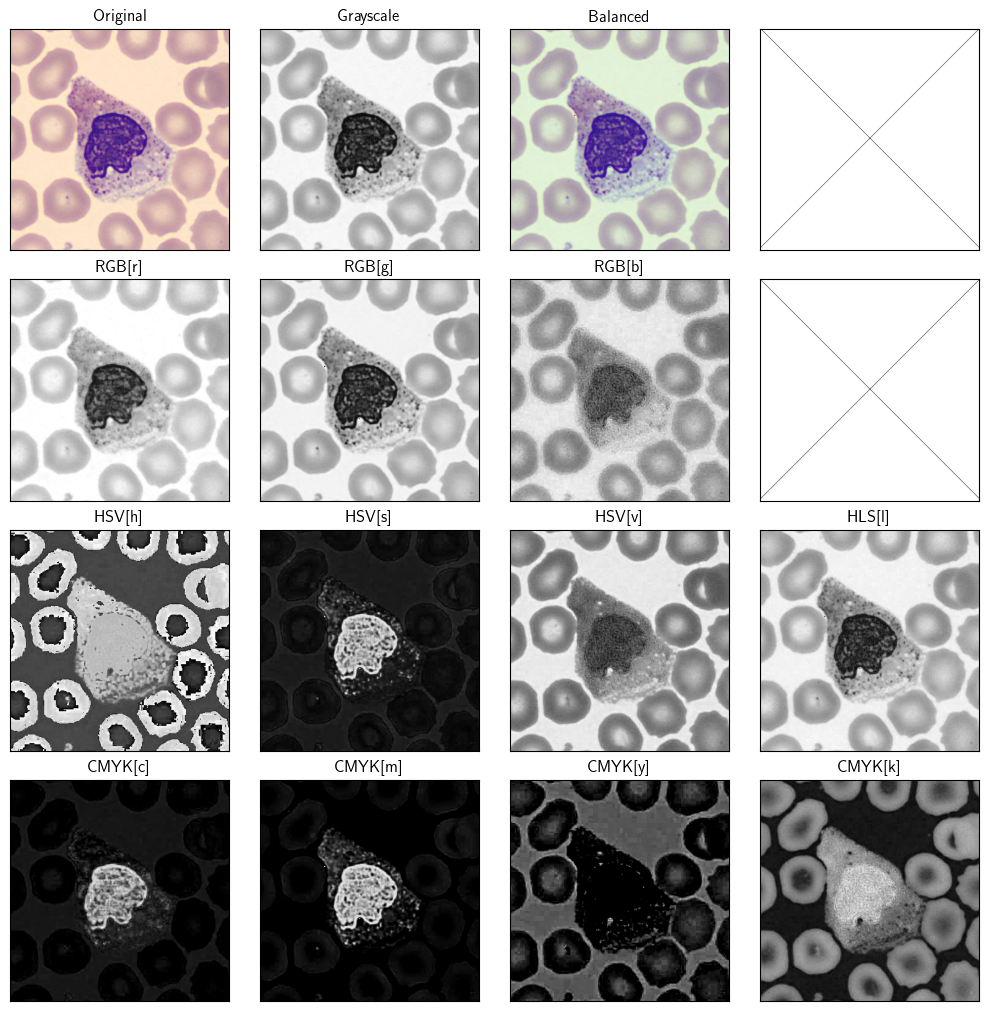

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


def rgb2cmyk(img):
    img = img.astype(np.float64) / 255.
    K = 1 - img.max(axis=2)
    C = (1 - img[..., 0] - K) / (1 - K)
    M = (1 - img[..., 1] - K) / (1 - K)
    Y = (1 - img[..., 2] - K) / (1 - K)
    return (np.dstack((C, M, Y, K)) * 255).astype(np.uint8)


blank = np.ones((363, 360)) * 255
np.fill_diagonal(blank, 0)
np.fill_diagonal(np.fliplr(blank), 0)
  
#filename = '/home/damien/yawbcc_data/barcelona/eosinophil/EO_11818.jpg'
filename = '/home/damien/yawbcc_data/barcelona/eosinophil/EO_45684.jpg'
filename = '/home/damien/yawbcc_data/barcelona/monocyte/MO_781658.jpg'
#filename = '/home/damien/yawbcc_data/barcelona/neutrophil/BNE_372073.jpg'
#filename = '/home/damien/yawbcc_data/barcelona/monocyte/MO_679959.jpg'
filename = '/home/damien/yawbcc_data/barcelona/ig/PMY_634329.jpg'
filename = '/home/damien/yawbcc_data/barcelona/ig/MY_470101.jpg'

img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
rgb = (img * gray.mean() / img.mean(axis=(0, 1))).astype(np.uint8)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV_FULL)
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS_FULL)
cmyk = rgb2cmyk(rgb)

R, G, B = cv2.split(rgb)
H, S, V = cv2.split(hsv)
_, L, _ = cv2.split(hls)
C, M, Y, K = cv2.split(cmyk)

import matplotlib as mpl
import matplotlib.gridspec as gridspec

tex_fonts = {
    'pgf.texsystem': 'pdflatex',
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm',
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
}
with mpl.rc_context(tex_fonts):

    fig, axs = plt.subplots(4, 4, figsize=(10, 10), layout='constrained')
    channels = [('Original', img), ('Grayscale', gray), ('Balanced', rgb), ('', blank),
                ('RGB[r]', R), ('RGB[g]', G), ('RGB[b]', B), ('', blank),
                ('HSV[h]', H), ('HSV[s]', S), ('HSV[v]', V), ('HLS[l]', L),
                ('CMYK[c]', C), ('CMYK[m]', M), ('CMYK[y]', Y), ('CMYK[k]', K)]

    for (name, channel), ax in zip(channels, axs.flat):
        ax.imshow(channel, cmap='gray' if len(channel.shape) == 2 else None)
        ax.set_title(name)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.tick_params(axis='y', which='both', left=False)
        ax.tick_params(axis='x', which='both', bottom=False)
    fig.savefig('../../image_color_channels.pdf')

# Réorientation d'une cellule (abandonné)

**Devant l'hétérogénité des images, il n'est pas possible d'appliquer cette technique.**

Si nous partons de l'hypothèse que chaque cellule d'un même type (basophile, éosinophile, etc) se développe d'une manière homogène et qu'à maturité, le noyau a des caractéristiques communes, notamment sa forme et sa position dans le cytoplasme. Il est donc possible de réorienter la cellule en fonction de la position de son noyau

Par soucis d'efficacité, nous partons de l'image binaire d'un noyau de neutrophile après segmentation. La méthode d'extraction est expliquée dans ce papier : [New segmentation and feature extraction algorithm for classification of white blood cells in peripheral smear images](https://www.nature.com/articles/s41598-021-98599-0)

Nous choisissons également arbitrairement l'origine au milieur de l'image. Dans la pratique, l'origine sera le milieu de la cellule après segmentation.

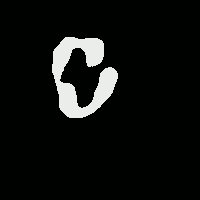

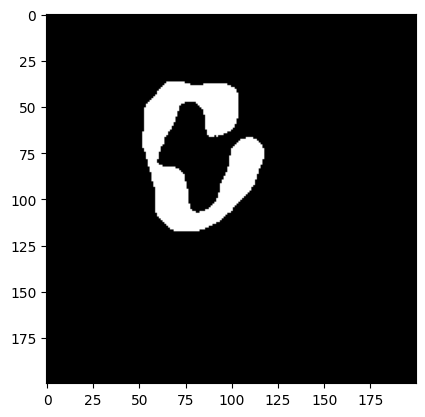

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image

# Image
data = "R0lGODlhyADIAKECAAACAOvt6v///////yH+EUNyZWF0ZWQgd2l0aCBHSU1QACH5BAEKAAIALAAAAADIAMgAAAL+hI+py+0Po5y02ouz3rz7D4biSJbmiabqyrbuC8fyTNf2jef6zvf+DwwKh8Si8YhMKpfMpvMJjUqn1Kr1is1qt9yu9wsOi8fksvmMTqvX7Lb7DY/L5/S6/Y7P6/f8PjYAGCjodyRoaLhwqEjoouj4CBnIqBJZaTk4WXK5aZk5wgkK6SkSWro46mGqiom6sfoa0OoKuyqbQftqe2GqkKtLUdpQ+zsR+qBKLBF8vJzMDBrR7CwMHW087XANIY3dW23N2U29CfwtnmC+HX6euK7szo4AD34Z711fjm8vr19Mvs+vU4V/AA/0yyeqoEGBuxIqXFjplqOH9xxikBSLYjv+iyxYOYvYceLHSCEfjeRogqEukpQOtkKpieBKkSi02TKZwubNQyt0yjqVM91PnkGFviRa0+dQSS3nzWRaVOYvpCeULkVU1elUlRys7nR5UetWqWHJJjOKECwxr/S4TmP7zOxZtG3dnpSrTuxdtXH5ztU7DvBauoH97gWZFrE9uBXtimOMDm83yBAdn6NsQPJjwo1xPsRs+DLngDABUra8j9vG0gVVR2apsbJk1K1dazaNDMDo2rhYx+7tO7Zu4FSFMyDu0XhhXMrfMW/uzxf0xIKnL6dtPS/s7Ny7e/8OPrz48eTLmz+PPr369ezbu38PP778+fTr27+PP7/+/fw9+/v/D2CAAg5IYIEGHohgggouyGCDDj4IYYQSTkhhhRZeiGGGGm7IYYcefghiiCKOSGKJJp6IYooqrjhiAQA7"
img = np.array(Image.open(io.BytesIO(base64.b64decode(data))))

# Variables
theta = np.linspace(0, 2*np.pi, 360).reshape(-1, 1)
orig = np.array([100, 100])
nuc = np.where(img)  # same as x and y

# Display image
plt.imshow(img, cmap='gray')
plt.show()

Il existe plusieurs possibilités pour réorienter la cellule. En s'inspirant de la mécanique, il suffirait de calculer l'énergie potentielle de chaque point du noyau par rapport à chaque angle θ et minimiser (ou maximiser) sa somme. Bien que la complexité de l'algorithme soit en $O^2$, la vectorisation avec `NumPy` est très rapide.

In [3]:
ep = np.sum((nuc[0] - orig[0]) * np.cos(theta) + (nuc[1] - orig[1]) * np.sin(theta), axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
ax1.imshow(img, cmap='gray')
ax1.set_title('Neutrophil')
ax2.plot(ep)
ax2.set_title('Énergie potentielle')
ax2.set_box_aspect(img.shape[0] / img.shape[1])

print(f'Theta min: {np.argmin(ep)}')
print(f'Theta max: {np.argmax(ep)}')

Theta min: 37
Theta max: 216


In [4]:
from scipy.ndimage import rotate

img_min = rotate(img, np.argmin(ep)+1, reshape=True)
img_max = rotate(img, np.argmax(ep)+1, reshape=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(img_min, cmap='gray')
ax1.set_title('Minimisation')
ax2.imshow(img_max, cmap='gray')
ax2.set_title('Maximisation')

Text(0.5, 1.0, 'Maximisation')

## Vérification

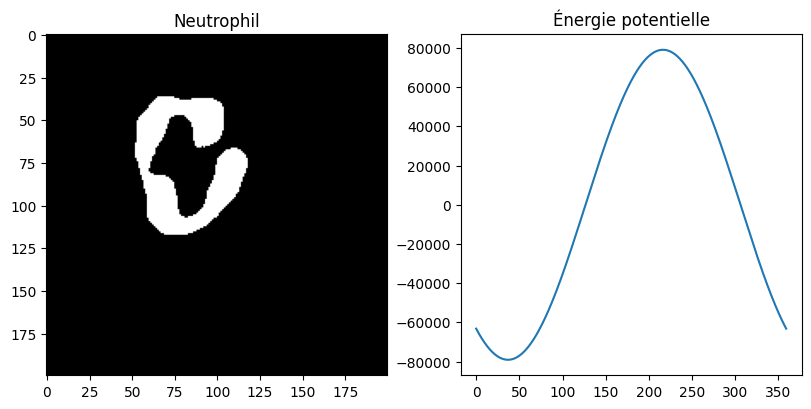

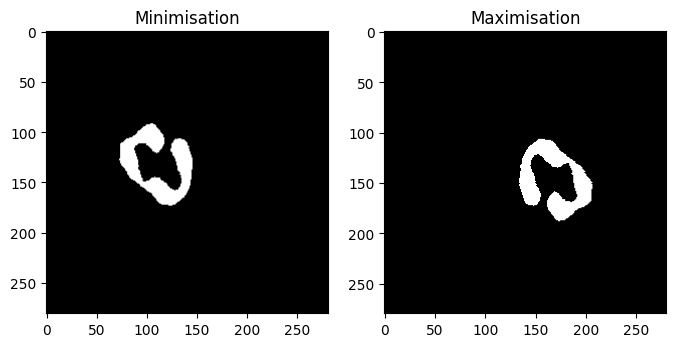

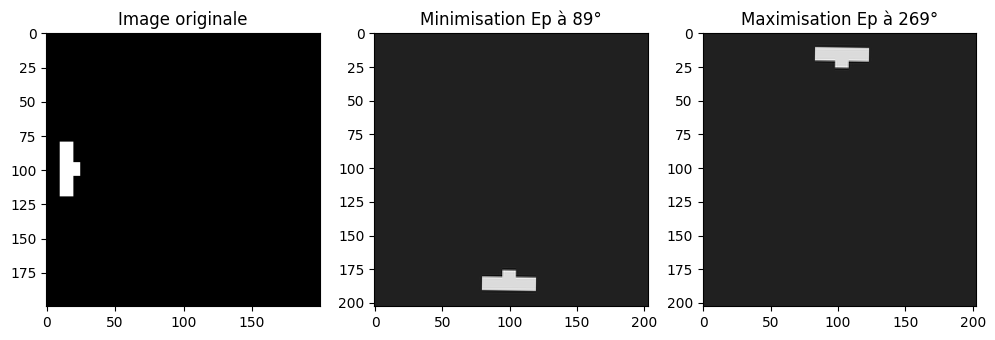

In [5]:
img2 = np.zeros((200, 200))
img2[80:120, 10:20] = 1
img2[95:105, 20:25] = 1

theta = np.linspace(0, 2*np.pi, 360).reshape(-1, 1)
orig = np.array([100, 100])
nuc2 = np.where(img2)

ep2 = np.sum((nuc2[0] - orig[0]) * np.cos(theta) + (nuc2[1] - orig[1]) * np.sin(theta), axis=1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(img2, cmap='gray')
ax2.imshow(rotate(img2, np.argmin(ep2), reshape=True), cmap='gray')
ax3.imshow(rotate(img2, np.argmax(ep2), reshape=True), cmap='gray')
ax1.set_title('Image originale')
ax2.set_title(f'Minimisation Ep à {np.argmin(ep2)}°')  # Expected ~90
ax3.set_title(f'Maximisation Ep à {np.argmax(ep2)}°')  # Expected ~270
plt.show()